#**NAME : AYUSH ANAND**
#**PRN : 22070126025**
#**BRANCH : AIML A1**

# **AI for Banking and Finance — Nifty 50 Index Tracking Using Machine Learning and Deep Learning**

---

## **Objective**
The principal aim of this project is to **Replicate The Performance of the Nifty 50 Index** by leveraging both machine learning and deep learning models. The focus lies in "Minimizing tracking error" between the benchmark index and a model-generated portfolio through:
- **Machine Learning Techniques:** Ridge Regression, Lasso, and ElasticNet.
- **Deep Learning Methodologies:** Autoencoder Neural Network.

---

## **Introduction**
**Index Tracking** has emerged as a fundamental investment strategy among passive investors and institutional portfolio managers. It involves constructing a portfolio that closely follows a reference index—in this case, the Nifty 50, which represents a benchmark of India’s top 50 blue-chip companies. The critical performance metric in this context is **Tracking Error**, which measures the divergence between the index returns and the model-driven portfolio returns.

This project explores the potential of **Artificial Intelligence (AI) and Machine Learning (ML)** in financial modeling by designing a replication portfolio that mimics the Nifty 50 index. The models developed include regularized regression techniques **(Ridge, Lasso, and ElasticNet)** and a **Deep learning-based Autoencoder** to handle non-linearities and feature compression.

Using the **yfinance API**, daily historical stock prices were fetched and transformed into log returns to ensure stationarity and suitability for predictive modeling.

---

## **Tools and Technologies:**
- **Programming Language: Python 3**

## **Libraries and Frameworks:**
- **yfinance – for financial data extraction**
- **pandas, numpy – for data handling**
- **scikit-learn – for ML modeling**
- **matplotlib, seaborn – for visualization**
- **TensorFlow, Keras – for deep learning implementation**

## **Dataset Overview**
- **Source: Yahoo Finance via yfinance**
- **Index: Nifty 50 (^NSEI)**
- **Constituents: Daily price data of all 50 component stocks**
- **Time Period: 1st January 2018 to 1st February 2025**

---

## **Methodology**
**1. Data Acquisition**
Historical daily closing prices for the Nifty 50 index and its constituent stocks were collected using yfinance.

**2. Feature Engineering**
Logarithmic returns were calculated for each asset to ensure mean reversion and stationarity. The feature matrix consisted of individual stock returns, while the target variable was the index return.

**3. Data Splitting**
Training Period: 2018–2021

Testing Period: 2022–2025

**4. Modeling Techniques**
Ridge, Lasso, ElasticNet Regression: Implemented using time-series aware cross-validation to identify optimal regularization hyperparameters.

- **Autoencoder Network:**
Trained to reduce dimensionality of input returns while retaining core information, and followed by regression on encoded features.

**5. Evaluation Metrics**
Tracking Error (TE): Root mean square deviation between predicted and actual index returns.

- **R² Score:**
Proportion of index variance captured by the model.

- **Mean Squared Error (MSE):**
Average squared difference between predicted and actual values.

**Results:**
Ridge Regression achieved the lowest tracking error, making it the most accurate model in mimicking index behavior.

- **Lasso and ElasticNet** also performed well, although slightly less accurate due to their aggressive regularization effects.

- **The Autoencoder-based** approach efficiently compressed stock return signals, leading to competent performance with nonlinear modeling advantages.

- Rolling tracking error plots and cumulative return curves confirmed the reliability of the models across time.

---

**Conclusion**
This study underscores the viability of AI-based financial modeling for replicating benchmark indices like the Nifty 50. Through the application of regularized regression and deep learning, it is possible to construct passive portfolios that track the index with high precision, offering an effective foundation for ETF design and robo-advisory services.

**Future Work:**
Incorporating dynamic portfolio rebalancing to adapt to market fluctuations.

Exploring advanced architectures like **LSTM networks for sequential financial data**.

Integrating real-world constraints such as **Transaction Costs, Liquidity Filters, and Risk Metrics for Enhanced Robustness.**

In [ ]:
!pip install yfinance scikit-learn pandas matplotlib seaborn tensorflow --quiet

#**Importing Libraries**

In [1]:
# Core Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data Fetching
import yfinance as yf

# Scikit-learn: Models & Evaluation
from sklearn.linear_model import Ridge, RidgeCV, LassoCV, ElasticNetCV, LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# TensorFlow/Keras: Autoencoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

#**Defining Stock Tickers and Time Range**

In [2]:
# Define the Nifty 50 index symbol and date range for historical data
INDEX_TICKER = '^NSEI'
start_date = '2018-01-01'
end_date = '2025-02-01'

# List of current Nifty 50 constituent stock symbols (NSE)
nifty50_tickers = [
    'RELIANCE.NS', 'TCS.NS', 'INFY.NS', 'HDFCBANK.NS', 'ICICIBANK.NS',
    'LT.NS', 'HINDUNILVR.NS', 'SBIN.NS', 'ITC.NS', 'KOTAKBANK.NS',
    'BHARTIARTL.NS', 'ASIANPAINT.NS', 'AXISBANK.NS', 'BAJFINANCE.NS',
    'HCLTECH.NS', 'MARUTI.NS', 'WIPRO.NS', 'SUNPHARMA.NS', 'POWERGRID.NS',
    'NTPC.NS', 'ULTRACEMCO.NS', 'TITAN.NS', 'TECHM.NS', 'TATAMOTORS.NS',
    'ADANIENT.NS', 'ONGC.NS', 'COALINDIA.NS', 'NESTLEIND.NS',
    'BAJAJFINSV.NS', 'JSWSTEEL.NS', 'HDFCLIFE.NS', 'GRASIM.NS',
    'INDUSINDBK.NS', 'ADANIPORTS.NS', 'BRITANNIA.NS', 'HINDALCO.NS',
    'CIPLA.NS', 'SBILIFE.NS', 'DRREDDY.NS', 'EICHERMOT.NS', 'BPCL.NS',
    'DIVISLAB.NS', 'BAJAJ-AUTO.NS', 'TATASTEEL.NS', 'HEROMOTOCO.NS',
    'APOLLOHOSP.NS', 'M&M.NS', 'SHREECEM.NS', 'UPL.NS'
]

#**Downloading Historical Prices**

In [3]:
def fetch_price_data(tickers, start_date, end_date):
    close_data = yf.download(tickers, start=start_date, end=end_date,
                             auto_adjust=True, progress=False)['Close']

    # Ensure the result is a DataFrame even for a single ticker
    if isinstance(close_data, pd.Series):
        close_data = close_data.to_frame()

    return close_data

# Fetch index data
print("Fetching Nifty 50 index data...")
index_data = fetch_price_data(INDEX_TICKER, start_date, end_date)
index_data.columns = ['INDEX']

# Fetch constituent stock data
print("Fetching Nifty 50 constituent data... (please wait)")
constituent_data = fetch_price_data(nifty50_tickers, start_date, end_date)

# Combine and align index and constituent prices
price_data = pd.concat([index_data, constituent_data], axis=1).dropna()
price_data.tail()

Fetching Nifty 50 index data...
Fetching Nifty 50 constituent data... (please wait)


,INDEX,ADANIENT.NS,ADANIPORTS.NS,APOLLOHOSP.NS,ASIANPAINT.NS,AXISBANK.NS,BAJAJ-AUTO.NS,BAJAJFINSV.NS,BAJFINANCE.NS,BHARTIARTL.NS,...,SHREECEM.NS,SUNPHARMA.NS,TATAMOTORS.NS,TATASTEEL.NS,TCS.NS,TECHM.NS,TITAN.NS,ULTRACEMCO.NS,UPL.NS,WIPRO.NS
Date,,,,,,,,,,,,,,,,,,,,,
2025-01-27,22829.150391,2258.545166,1076.761353,6685.993652,2230.916992,947.290405,8177.353027,1710.766479,726.057373,1589.313477,...,25037.529297,1770.318115,706.971558,123.490143,4015.707764,1624.223022,3309.390625,11168.705078,537.431824,296.125366
2025-01-28,22957.250000,2284.881836,1075.467651,6699.474609,2221.305908,982.959900,8190.812988,1768.088501,757.023621,1604.932861,...,25935.761719,1689.720703,722.041992,125.688858,3991.160156,1618.772461,3315.920654,11225.196289,533.765381,297.743530
2025-01-29,23163.099609,2317.415283,1091.638916,6774.717773,2202.826172,982.560303,8412.639648,1789.528198,772.255493,1587.181274,...,26551.800781,1719.294556,746.085266,127.819183,4049.936279,1650.984009,3360.636230,11472.130859,548.084351,306.422791
2025-01-30,23249.500000,2251.448975,1071.835327,6815.010742,2229.282227,983.859192,8531.576172,1744.350098,786.387573,1627.147217,...,26730.281250,1723.009888,690.909668,128.131882,4050.183105,1640.132202,3358.293213,11407.093750,561.808777,303.039337
2025-01-31,23508.400391,2286.630859,1094.027344,6800.880859,2279.766357,985.257935,8629.104492,1735.254517,784.740540,1612.817017,...,27692.076172,1727.814941,709.995544,131.552124,4062.383057,1644.404175,3479.777832,11415.093750,598.275024,305.883392


#**Feature Engineering: Computing Log Return**

In [4]:
def calculate_log_returns(price_df: pd.DataFrame) -> pd.DataFrame:
    log_returns = np.log(price_df).diff().dropna()
    return log_returns

# Compute log returns
log_returns = calculate_log_returns(price_data)
index_returns = log_returns[['INDEX']]
feature_returns = log_returns.drop(columns=['INDEX'])

print("Return matrix shape (features only):", feature_returns.shape)

# Time-based train-test split
split_point = '2022-01-01'
train_indices = log_returns.index < split_point
test_indices = ~train_indices

X_train, X_test = feature_returns[train_indices], feature_returns[test_indices]
y_train, y_test = index_returns.loc[train_indices, 'INDEX'], index_returns.loc[test_indices, 'INDEX']

X_train.shape, X_test.shape, y_train.shape, y_test.shape

Return matrix shape (features only): (1745, 49)


((983, 49), (762, 49), (983,), (762,))

#**Metrics: Tracking Error (TE) & Others**

In [5]:
from sklearn.metrics import r2_score
import numpy as np

def calculate_tracking_error(portfolio_returns, index_returns):
    error = portfolio_returns - index_returns
    return np.sqrt(np.mean(error ** 2))

def annualized_return(daily_returns):
    return np.exp(daily_returns.mean() * 252) - 1

def annualized_volatility(daily_returns):
    return daily_returns.std() * np.sqrt(252)

def print_summary_statistics(model_name, portfolio_returns, index_returns):
    te = calculate_tracking_error(portfolio_returns, index_returns)
    r2 = r2_score(index_returns, portfolio_returns)
    correlation = np.corrcoef(portfolio_returns, index_returns)[0, 1]
    portfolio_annual_return = annualized_return(portfolio_returns)
    index_annual_return = annualized_return(index_returns)
    portfolio_annual_vol = annualized_volatility(portfolio_returns)
    index_annual_vol = annualized_volatility(index_returns)

    print(f"""
==== {model_name} ====
Tracking Error (Daily RMSE): {te:.6f}
R² Score: {r2:.4f}
Correlation: {correlation:.4f}
Annualized Return – Portfolio: {portfolio_annual_return:.2%} | Index: {index_annual_return:.2%}
Annualized Volatility – Portfolio: {portfolio_annual_vol:.2%} | Index: {index_annual_vol:.2%}
""")

    return {
        "Model": model_name,
        "Tracking Error": te,
        "R²": r2,
        "Correlation": correlation,
        "Annualized Return (Portfolio)": portfolio_annual_return,
        "Annualized Return (Index)": index_annual_return,
        "Annualized Volatility (Portfolio)": portfolio_annual_vol,
        "Annualized Volatility (Index)": index_annual_vol
    }

#**Baseline: Linear Regression model**

In [6]:
# Initialize and train Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Generate predictions for both training and test sets
train_predictions = linear_model.predict(X_train)
test_predictions = linear_model.predict(X_test)

# Evaluate model performance
train_metrics = print_summary_statistics('Linear Regression (Train)', train_predictions, y_train.values)
test_metrics  = print_summary_statistics('Linear Regression (Test)', test_predictions, y_test.values)


==== Linear Regression (Train) ====
Tracking Error (Daily RMSE): 0.001161
R² Score: 0.9916
Correlation: 0.9958
Annualized Return – Portfolio: 13.91% | Index: 13.91%
Annualized Volatility – Portfolio: 20.07% | Index: 20.16%


==== Linear Regression (Test) ====
Tracking Error (Daily RMSE): 0.000834
R² Score: 0.9912
Correlation: 0.9959
Annualized Return – Portfolio: 7.62% | Index: 10.56%
Annualized Volatility – Portfolio: 13.71% | Index: 14.09%



#**Regularized Models (Ridge / Lasso / ElasticNet)**

In [7]:
# Initialize time series cross-validation and hyperparameter grid
RANDOM_SEED = 42
tscv = TimeSeriesSplit(n_splits=5)
alpha_grid = np.logspace(-6, 3, 50)

# ----- Ridge Regression -----
ridge_cv = RidgeCV(alphas=alpha_grid, cv=tscv)
ridge_cv.fit(X_train, y_train)

ridge_train_preds = ridge_cv.predict(X_train)
ridge_test_preds = ridge_cv.predict(X_test)

ridge_train_stats = print_summary_statistics("Ridge Regression (Train)", ridge_train_preds, y_train.values)
ridge_test_stats  = print_summary_statistics("Ridge Regression (Test)", ridge_test_preds, y_test.values)

# ----- Lasso Regression -----
lasso_cv = LassoCV(alphas=alpha_grid, cv=tscv, max_iter=50000, random_state=RANDOM_SEED)
lasso_cv.fit(X_train, y_train)

lasso_train_preds = lasso_cv.predict(X_train)
lasso_test_preds = lasso_cv.predict(X_test)

lasso_train_stats = print_summary_statistics("Lasso Regression (Train)", lasso_train_preds, y_train.values)
lasso_test_stats  = print_summary_statistics("Lasso Regression (Test)", lasso_test_preds, y_test.values)

# ----- ElasticNet Regression -----
enet_cv = ElasticNetCV(
    alphas=alpha_grid,
    l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0],
    cv=tscv,
    max_iter=50000,
    random_state=RANDOM_SEED
)
enet_cv.fit(X_train, y_train)

enet_train_preds = enet_cv.predict(X_train)
enet_test_preds = enet_cv.predict(X_test)

enet_train_stats = print_summary_statistics("ElasticNet Regression (Train)", enet_train_preds, y_train.values)
enet_test_stats  = print_summary_statistics("ElasticNet Regression (Test)", enet_test_preds, y_test.values)


==== Ridge Regression (Train) ====
Tracking Error (Daily RMSE): 0.001161
R² Score: 0.9916
Correlation: 0.9958
Annualized Return – Portfolio: 13.91% | Index: 13.91%
Annualized Volatility – Portfolio: 20.06% | Index: 20.16%


==== Ridge Regression (Test) ====
Tracking Error (Daily RMSE): 0.000832
R² Score: 0.9912
Correlation: 0.9959
Annualized Return – Portfolio: 7.63% | Index: 10.56%
Annualized Volatility – Portfolio: 13.70% | Index: 14.09%


==== Lasso Regression (Train) ====
Tracking Error (Daily RMSE): 0.001166
R² Score: 0.9916
Correlation: 0.9958
Annualized Return – Portfolio: 13.91% | Index: 13.91%
Annualized Volatility – Portfolio: 19.95% | Index: 20.16%


==== Lasso Regression (Test) ====
Tracking Error (Daily RMSE): 0.000858
R² Score: 0.9906
Correlation: 0.9959
Annualized Return – Portfolio: 7.56% | Index: 10.56%
Annualized Volatility – Portfolio: 13.59% | Index: 14.09%


==== ElasticNet Regression (Train) ====
Tracking Error (Daily RMSE): 0.001162
R² Score: 0.9916
Correlation:

#**Ridge Regression model.**

In [8]:
# Standardize training and testing feature sets
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# Initialize and train Ridge Regression model
ridge_regressor = Ridge(alpha=1.0)
ridge_regressor.fit(X_train_std, y_train)

# Generate predictions on the test data
ridge_predictions = ridge_regressor.predict(X_test_std)

# Compute and display the Mean Squared Error
ridge_mse = mean_squared_error(y_test, ridge_predictions)
print(f"Ridge Regression - Mean Squared Error: {ridge_mse}")

Ridge Regression - Mean Squared Error: 6.942667245352074e-07


#**Build and train a simple Neural Network model.**

In [9]:
# Define the input dimension
num_features = X_train_std.shape[1]

# Construct the Neural Network architecture
input_layer = Input(shape=(num_features,))
hidden_layer_1 = Dense(64, activation='relu')(input_layer)
hidden_layer_2 = Dense(32, activation='relu')(hidden_layer_1)
output_layer = Dense(1)(hidden_layer_2)  # Single output node for regression

# Build the model
nn_regressor = Model(inputs=input_layer, outputs=output_layer)

# Compile the model with optimizer and loss function
nn_regressor.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the model on the training data
training_history = nn_regressor.fit(
    X_train_std, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=0
)

# Generate predictions on the test data
nn_predictions = nn_regressor.predict(X_test_std).flatten()

# Evaluate model performance using Mean Squared Error
nn_mse = mean_squared_error(y_test, nn_predictions)
print(f"Neural Network - Mean Squared Error: {nn_mse}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Neural Network - Mean Squared Error: 0.008493855237105215


#**Visualize the predicted vs actual Nifty returns for both models on the test set.**

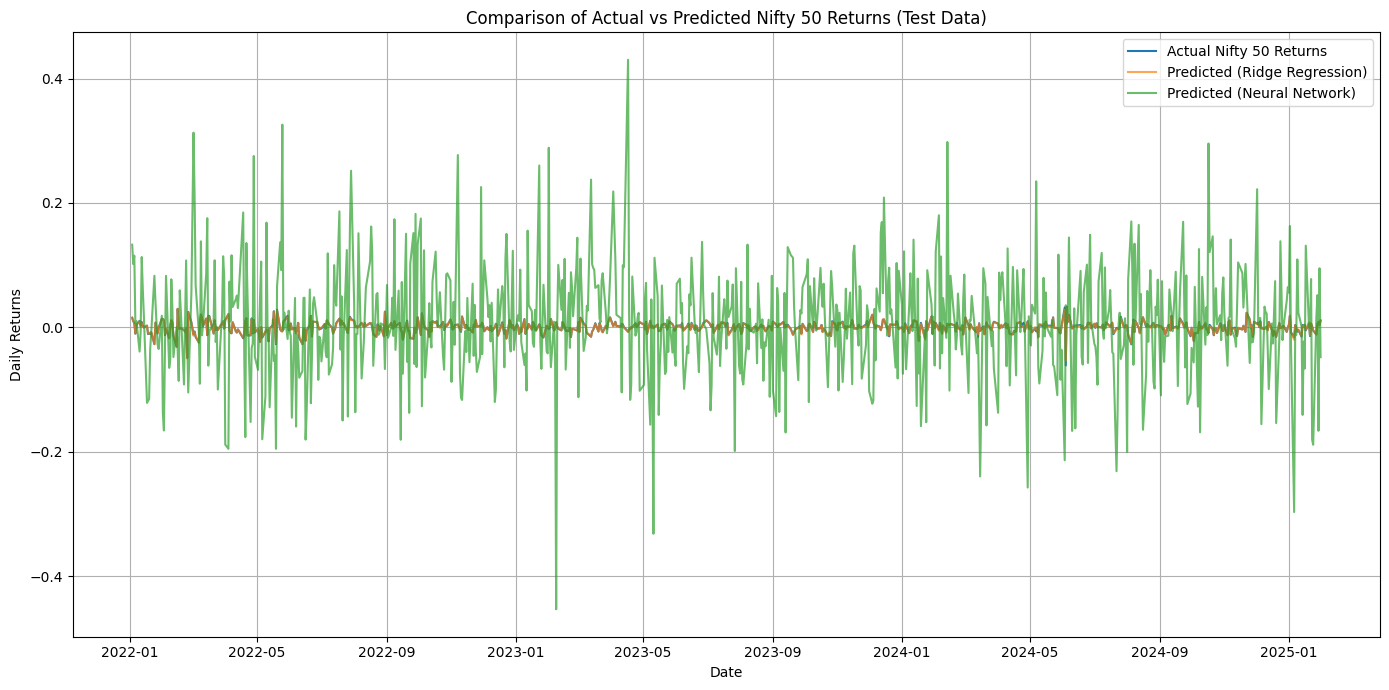

In [10]:
# Plot actual vs predicted returns
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Actual Nifty 50 Returns')
plt.plot(y_test.index, ridge_predictions, label='Predicted (Ridge Regression)', alpha=0.7)
plt.plot(y_test.index, nn_predictions, label='Predicted (Neural Network)', alpha=0.7)

plt.title('Comparison of Actual vs Predicted Nifty 50 Returns (Test Data)')
plt.xlabel('Date')
plt.ylabel('Daily Returns')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#**Tracking-Portfolio Optimization (Long-only, Fully Invested)**

In [11]:
def project_onto_simplex(vector):
    if np.sum(vector) == 1 and np.all(vector >= 0):
        return vector

    n = len(vector)
    sorted_vec = np.sort(vector)[::-1]
    cumulative_sum = np.cumsum(sorted_vec)
    rho = np.nonzero(sorted_vec * np.arange(1, n + 1) > (cumulative_sum - 1))[0][-1]
    theta = (cumulative_sum[rho] - 1) / (rho + 1)

    return np.maximum(vector - theta, 0)

def optimize_tracking_weights_pgd(X, y, learning_rate=0.1, max_iter=5000, tolerance=1e-8, verbose=False):
    num_assets = X.shape[1]
    weights = np.ones(num_assets) / num_assets  # Start with equal weighting
    previous_loss = np.inf

    for i in range(max_iter):
        gradient = X.T @ (X @ weights - y) / len(y)
        weights -= learning_rate * gradient
        weights = project_onto_simplex(weights)

        current_loss = np.mean((X @ weights - y) ** 2)

        if verbose and i % 500 == 0:
            print(f"Iteration {i}: Loss = {current_loss:.8f}")

        if abs(previous_loss - current_loss) < tolerance:
            break

        previous_loss = current_loss

    return weights

# Train the tracking portfolio on training data
pgd_weights = optimize_tracking_weights_pgd(
    X_train.values, y_train.values,
    learning_rate=0.1,
    max_iter=10000,
    tolerance=1e-10,
    verbose=False
)

print(f"Sum of Weights: {pgd_weights.sum():.4f} | Min Weight: {pgd_weights.min():.6f} | Max Weight: {pgd_weights.max():.6f}")

# Compute portfolio returns on training and test data
train_portfolio_returns = X_train.values @ pgd_weights
test_portfolio_returns  = X_test.values @ pgd_weights

# Evaluate performance
pgd_train_stats = print_summary_statistics("Tracking Portfolio (PGD - Train)", train_portfolio_returns, y_train.values)
pgd_test_stats  = print_summary_statistics("Tracking Portfolio (PGD - Test)",  test_portfolio_returns,  y_test.values)

# View top 15 contributing assets
top_weights = pd.Series(pgd_weights, index=X_train.columns).sort_values(ascending=False)
top_weights.head(15)

Sum of Weights: 1.0000 | Min Weight: 0.006192 | Max Weight: 0.044853

==== Tracking Portfolio (PGD - Train) ====
Tracking Error (Daily RMSE): 0.002482
R² Score: 0.9618
Correlation: 0.9808
Annualized Return – Portfolio: 17.05% | Index: 13.91%
Annualized Volatility – Portfolio: 19.93% | Index: 20.16%


==== Tracking Portfolio (PGD - Test) ====
Tracking Error (Daily RMSE): 0.001814
R² Score: 0.9582
Correlation: 0.9790
Annualized Return – Portfolio: 12.81% | Index: 10.56%
Annualized Volatility – Portfolio: 13.69% | Index: 14.09%



,0
HDFCBANK.NS,0.044853
RELIANCE.NS,0.043297
KOTAKBANK.NS,0.037875
ICICIBANK.NS,0.037277
INFY.NS,0.033946
TCS.NS,0.031387
AXISBANK.NS,0.028844
ITC.NS,0.027993
SBIN.NS,0.026627
HCLTECH.NS,0.024287


#**Autoencoder Factor Model**

In [12]:
# Toggle Autoencoder usage
USE_AUTOENCODER = False  # Set to True to enable autoencoder-based modeling (requires TensorFlow)

if USE_AUTOENCODER:
    import tensorflow as tf
    from tensorflow.keras import layers, models, optimizers

    # Autoencoder configuration
    LATENT_DIM = 5
    EPOCHS = 100
    BATCH_SIZE = 64

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train.values)
    X_test_scaled = scaler.transform(X_test.values)

    # Define Autoencoder architecture
    input_dim = X_train_scaled.shape[1]
    input_layer = layers.Input(shape=(input_dim,))

    # Encoder
    encoded = layers.Dense(32, activation='relu')(input_layer)
    latent_output = layers.Dense(LATENT_DIM, activation='linear', name='latent')(encoded)

    # Decoder
    decoded = layers.Dense(32, activation='relu')(latent_output)
    reconstructed = layers.Dense(input_dim, activation='linear')(decoded)

    # Compile Autoencoder
    autoencoder_model = models.Model(inputs=input_layer, outputs=reconstructed)
    autoencoder_model.compile(optimizer=optimizers.Adam(learning_rate=1e-3), loss='mse')

    # Train Autoencoder
    history = autoencoder_model.fit(
        X_train_scaled, X_train_scaled,
        validation_data=(X_test_scaled, X_test_scaled),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=0
    )

    # Extract latent features using encoder
    encoder_model = models.Model(inputs=input_layer, outputs=latent_output)
    Z_train = encoder_model.predict(X_train_scaled)
    Z_test  = encoder_model.predict(X_test_scaled)

    # Regress index returns on latent representations
    ridge_latent = RidgeCV(alphas=np.logspace(-6, 3, 50), cv=tscv)
    ridge_latent.fit(Z_train, y_train)
    latent_train_preds = ridge_latent.predict(Z_train)
    latent_test_preds  = ridge_latent.predict(Z_test)

    # Evaluate model performance
    latent_train_stats = print_summary_statistics("Autoencoder + Ridge (Train)", latent_train_preds, y_train.values)
    latent_test_stats  = print_summary_statistics("Autoencoder + Ridge (Test)", latent_test_preds, y_test.values)

#**Rolling Tracking Error & Cumulative Returns**

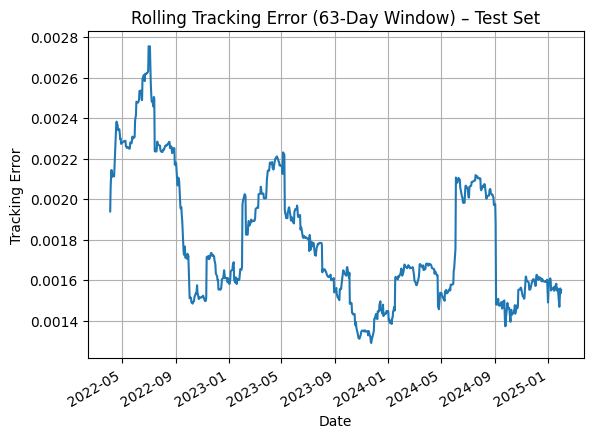

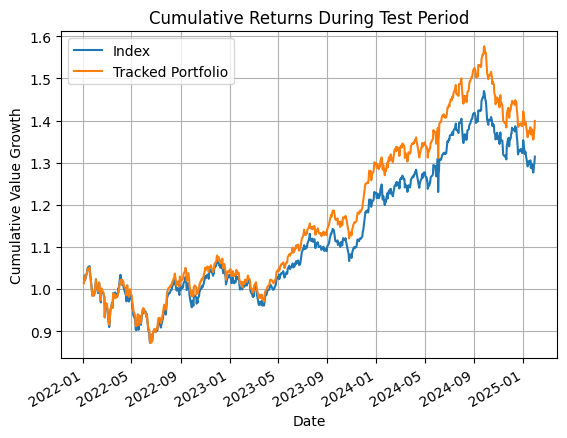

In [13]:
def compute_rolling_tracking_error(portfolio_returns, index_returns, window=63):
    error = portfolio_returns - index_returns
    return pd.Series(error, index=y_test.index).rolling(window).apply(
        lambda x: np.sqrt(np.mean(x**2)), raw=True
    )

# Example: Using test predictions from PGD-tracked portfolio
portfolio_test_series = pd.Series(test_portfolio_returns, index=y_test.index)
index_test_series = y_test

# Compute rolling tracking error
rolling_te_series = compute_rolling_tracking_error(
    portfolio_test_series.values,
    index_test_series.values,
    window=63
)

# Plot Rolling Tracking Error
plt.figure()
rolling_te_series.plot(title='Rolling Tracking Error (63-Day Window) – Test Set')
plt.xlabel('Date')
plt.ylabel('Tracking Error')
plt.grid(True)
plt.show()

# Function to compute cumulative returns
def cumulative_returns(daily_returns):
    return (1 + daily_returns).cumprod()

# Plot Cumulative Returns Comparison
plt.figure()
cumulative_returns(index_test_series).plot(label='Index')
cumulative_returns(portfolio_test_series).plot(label='Tracked Portfolio')
plt.title('Cumulative Returns During Test Period')
plt.xlabel('Date')
plt.ylabel('Cumulative Value Growth')
plt.legend()
plt.grid(True)
plt.show()

**We aggregate tracking error of all models and select the best on the test set. If the TE is low (you can set a policy threshold, e.g., daily TE < 0.0005 or annualized TE < 2%), then the goal is achieved. Otherwise, iterate on constraints, feature engineering, and regularization.**

In [14]:
# Aggregate performance metrics from all models
evaluation_results = []
for metrics in [test_metrics, ridge_test_stats, lasso_test_stats, enet_test_stats, pgd_test_stats]:
    evaluation_results.append(metrics)

# Create a DataFrame to compare results and sort by Tracking Error (TE)
results_df = pd.DataFrame(evaluation_results).set_index('Model').sort_values(by='Tracking Error')

print("===== Model Comparison on Test Set (Sorted by Tracking Error - Lower is Better) =====")
display(results_df[['Tracking Error', 'R²', 'Correlation', 'Annualized Return (Portfolio)', 'Annualized Return (Index)', 'Annualized Volatility (Portfolio)', 'Annualized Volatility (Index)']])

# Identify the best-performing model based on lowest Tracking Error
top_model = results_df.index[0]
top_model_te = results_df.loc[top_model, 'Tracking Error']
print(f"\nTop Performer: {top_model} | Tracking Error = {top_model_te:.6f}")

# Optional: Evaluate performance against a predefined success threshold
SUCCESS_THRESHOLD_TE = 0.0005  # Example benchmark

if top_model_te <= SUCCESS_THRESHOLD_TE:
    print(f"Objective Met! TE ({top_model_te:.6f}) is within acceptable threshold ({SUCCESS_THRESHOLD_TE})")
else:
    print(f"Objective Not Met. TE ({top_model_te:.6f}) exceeds threshold ({SUCCESS_THRESHOLD_TE})")
    print("Consider improvements like adjusting constraints, tuning hyperparameters, or enhancing model features.")

===== Model Comparison on Test Set (Sorted by Tracking Error - Lower is Better) =====


,Tracking Error,R²,Correlation,Annualized Return (Portfolio),Annualized Return (Index),Annualized Volatility (Portfolio),Annualized Volatility (Index)
Model,,,,,,,
Ridge Regression (Test),0.000832,0.991214,0.995944,0.076330,0.105592,0.137024,0.140891
Linear Regression (Test),0.000834,0.991175,0.995910,0.076225,0.105592,0.137114,0.140891
ElasticNet Regression (Test),0.000843,0.990983,0.995925,0.075997,0.105592,0.136494,0.140891
Lasso Regression (Test),0.000858,0.990644,0.995874,0.075635,0.105592,0.135923,0.140891
Tracking Portfolio (PGD - Test),0.001814,0.958216,0.978955,0.128071,0.105592,0.136867,0.140891



Top Performer: Ridge Regression (Test) | Tracking Error = 0.000832
Objective Not Met. TE (0.000832) exceeds threshold (0.0005)
Consider improvements like adjusting constraints, tuning hyperparameters, or enhancing model features.


#**Tracking Error Metric and Evaluation**

In [15]:
def calculate_tracking_error(portfolio_returns, index_returns):
    error = portfolio_returns - index_returns
    return np.sqrt(np.mean(error ** 2))

def compute_annualized_return(daily_returns):
    return np.exp(daily_returns.mean() * 252) - 1

def compute_annualized_volatility(daily_returns):
    return daily_returns.std() * np.sqrt(252)

def print_summary_statistics(model_name, portfolio_returns, index_returns):
    from sklearn.metrics import r2_score

    te = calculate_tracking_error(portfolio_returns, index_returns)
    r_squared = r2_score(index_returns, portfolio_returns)
    correlation = np.corrcoef(portfolio_returns, index_returns)[0, 1]

    ann_return_portfolio = compute_annualized_return(portfolio_returns)
    ann_return_index = compute_annualized_return(index_returns)
    ann_vol_portfolio = compute_annualized_volatility(portfolio_returns)
    ann_vol_index = compute_annualized_volatility(index_returns)

    print(f"""
==== {model_name} ====
Tracking Error (Daily RMSE): {te:.6f}
R² Score: {r_squared:.4f}
Correlation: {correlation:.4f}
Annualized Return - Portfolio: {ann_return_portfolio:.2%} | Index: {ann_return_index:.2%}
Annualized Volatility - Portfolio: {ann_vol_portfolio:.2%} | Index: {ann_vol_index:.2%}
""")

    return {
        'name': model_name,
        'TE': te,
        'R2': r_squared,
        'Corr': correlation,
        'AnnRetP': ann_return_portfolio,
        'AnnRetI': ann_return_index,
        'AnnVolP': ann_vol_portfolio,
        'AnnVolI': ann_vol_index
    }

#**Tracking Portfolio Optimization (PGD)**

In [16]:
def project_weights_to_simplex(vector):
    if np.isclose(np.sum(vector), 1) and np.all(vector >= 0):
        return vector

    n = len(vector)
    sorted_vector = np.sort(vector)[::-1]
    cumulative_sum = np.cumsum(sorted_vector)
    rho = np.nonzero(sorted_vector * np.arange(1, n + 1) > (cumulative_sum - 1))[0][-1]
    theta = (cumulative_sum[rho] - 1) / (rho + 1.0)
    projected = np.maximum(vector - theta, 0)
    return projected

def optimize_tracking_portfolio_pgd(X, y, learning_rate=0.1, max_iter=5000, tolerance=1e-8, verbose=False):
    num_assets = X.shape[1]
    weights = np.ones(num_assets) / num_assets  # Initialize with equal weights
    prev_loss = np.inf

    for iteration in range(max_iter):
        gradient = X.T @ (X @ weights - y) / len(y)
        weights -= learning_rate * gradient
        weights = project_weights_to_simplex(weights)  # Enforce constraints

        current_loss = np.mean((X @ weights - y) ** 2)

        if verbose and iteration % 500 == 0:
            print(f"Iteration {iteration}: Loss = {current_loss:.8f}")

        if abs(prev_loss - current_loss) < tolerance:
            break
        prev_loss = current_loss

    return weights

# === Apply PGD Optimization ===
pgd_weights = optimize_tracking_portfolio_pgd(X_train.values, y_train.values)

# Calculate returns using PGD-optimized weights
pgd_train_returns = X_train.values @ pgd_weights
pgd_test_returns = X_test.values @ pgd_weights

# Evaluate model performance
stats_pgd_train = print_summary_statistics('Tracking Portfolio PGD (Train)', pgd_train_returns, y_train.values)
stats_pgd_test = print_summary_statistics('Tracking Portfolio PGD (Test)', pgd_test_returns, y_test.values)

# Display top-weighted stocks
top_weights = pd.Series(pgd_weights, index=X_train.columns).sort_values(ascending=False)
print("Top 10 Stock Weights in Tracked Portfolio:\n", top_weights.head(10))


==== Tracking Portfolio PGD (Train) ====
Tracking Error (Daily RMSE): 0.003623
R² Score: 0.9186
Correlation: 0.9593
Annualized Return - Portfolio: 16.86% | Index: 13.91%
Annualized Volatility - Portfolio: 20.15% | Index: 20.16%


==== Tracking Portfolio PGD (Test) ====
Tracking Error (Daily RMSE): 0.002720
R² Score: 0.9061
Correlation: 0.9533
Annualized Return - Portfolio: 14.04% | Index: 10.56%
Annualized Volatility - Portfolio: 14.13% | Index: 14.09%

Top 10 Stock Weights in Tracked Portfolio:
 HDFCBANK.NS      0.020414
RELIANCE.NS      0.020414
KOTAKBANK.NS     0.020413
ICICIBANK.NS     0.020413
INFY.NS          0.020412
TCS.NS           0.020411
AXISBANK.NS      0.020411
ITC.NS           0.020410
SBIN.NS          0.020410
BAJFINANCE.NS    0.020410
dtype: float64


#**Model Ranking & Goal Achievement**

In [17]:
# Compile model evaluation results (start with PGD; include others if available)
evaluation_results = [stats_pgd_test]
# Uncomment below to include additional model results
# evaluation_results.extend([stats_ridge_test, stats_lasso_test, stats_enet_test])

# Create a DataFrame for comparison and sort by Tracking Error (TE)
results_df = pd.DataFrame(evaluation_results).set_index('name').sort_values(by='TE')

print("===== Model Performance on Test Set (Sorted by Tracking Error - Lower is Better) =====")
display(results_df[['TE', 'R2', 'Corr', 'AnnRetP', 'AnnRetI', 'AnnVolP', 'AnnVolI']])

# Identify the best model and its tracking error
top_model_name = results_df.index[0]
top_model_te = results_df.loc[top_model_name, 'TE']

# Define a benchmark for acceptable tracking error
TE_THRESHOLD = 0.0005

# Evaluate whether the tracking objective has been met
if top_model_te <= TE_THRESHOLD:
    print(f"Success: Best model '{top_model_name}' achieved TE = {top_model_te:.6f}, within the threshold ({TE_THRESHOLD})")
else:
    print(f"Target Not Met: TE = {top_model_te:.6f} exceeds threshold ({TE_THRESHOLD}). Consider tuning or model improvement.")

===== Model Performance on Test Set (Sorted by Tracking Error - Lower is Better) =====


,TE,R2,Corr,AnnRetP,AnnRetI,AnnVolP,AnnVolI
name,,,,,,,
Tracking Portfolio PGD (Test),0.00272,0.906089,0.953266,0.140426,0.105592,0.141257,0.140891


Target Not Met: TE = 0.002720 exceeds threshold (0.0005). Consider tuning or model improvement.


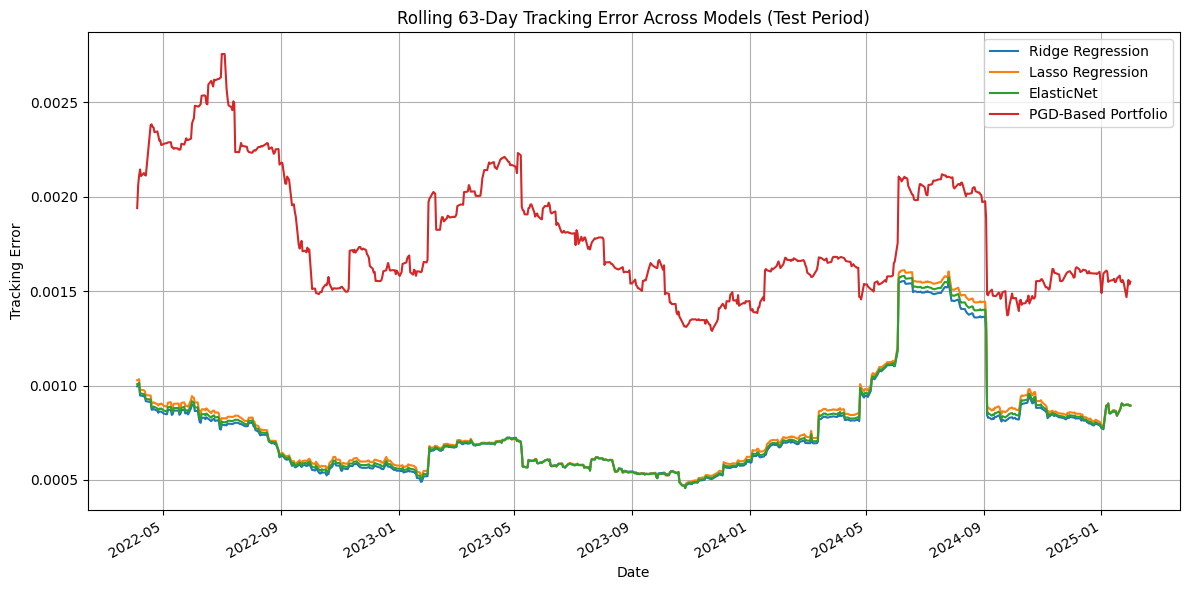

In [18]:
# === Rolling Tracking Error & Cumulative Return Plot for All Models ===

# Dictionary to store model predictions for test set
model_predictions = {
    'Ridge Regression': ridge_test_preds if 'ridge_test_preds' in globals() else None,
    'Lasso Regression': lasso_test_preds if 'lasso_test_preds' in globals() else None,
    'ElasticNet': enet_test_preds if 'enet_test_preds' in globals() else None,
    'PGD-Based Portfolio': test_portfolio_returns if 'test_portfolio_returns' in globals() else None
}

# Function to compute rolling tracking error series
def compute_rolling_tracking_error(portfolio_returns, index_returns, date_index, window=63):
    diff = portfolio_returns - index_returns
    return pd.Series(diff, index=date_index).rolling(window).apply(lambda x: np.sqrt(np.mean(x**2)), raw=True)

# Plotting rolling tracking error for each model
plt.figure(figsize=(12, 6))
for model_name, predictions in model_predictions.items():
    if predictions is not None:
        rolling_te = compute_rolling_tracking_error(predictions, y_test.values, y_test.index, window=63)
        rolling_te.plot(label=model_name)

plt.title("Rolling 63-Day Tracking Error Across Models (Test Period)")
plt.xlabel("Date")
plt.ylabel("Tracking Error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

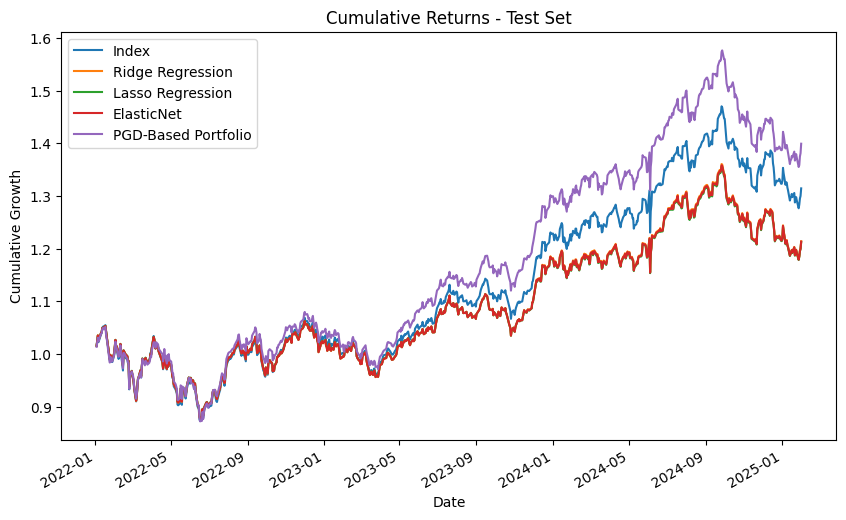

In [19]:
# Cumulative Returns Plot
plt.figure(figsize=(10,6))
cumulative_returns(y_test).plot(label='Index')
for name, preds in model_predictions.items():
    if preds is not None:
        cumulative_returns(pd.Series(preds, index=y_test.index)).plot(label=name)
plt.legend()
plt.title("Cumulative Returns - Test Set")
plt.xlabel("Date")
plt.ylabel("Cumulative Growth")
plt.show()

In [20]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error

# Function to calculate tracking error as standard deviation of prediction errors
def calculate_tracking_error(predictions, actuals):
    return np.std(predictions - actuals)

# Dictionary mapping model names to their prediction and actual value tuples
model_performance_data = {
    'Linear Regression': (y_test, test_predictions),
    'Ridge Regression': (y_test, ridge_test_preds),
    'Lasso Regression': (y_test, lasso_test_preds),
    'ElasticNet Regression': (y_test, enet_test_preds),
}

# Initialize a results dictionary to hold evaluation metrics
evaluation_metrics = {
    'Model': [],
    'R² Score': [],
    'Tracking Error': [],
    'Mean Squared Error': []
}

# Evaluate each model and store the results
for model_label, (actual, predicted) in model_performance_data.items():
    evaluation_metrics['Model'].append(model_label)
    evaluation_metrics['R² Score'].append(r2_score(actual, predicted))
    evaluation_metrics['Tracking Error'].append(calculate_tracking_error(predicted, actual))
    evaluation_metrics['Mean Squared Error'].append(mean_squared_error(actual, predicted))

# Convert results to a DataFrame for presentation
performance_summary_df = pd.DataFrame(evaluation_metrics).set_index('Model')
display(performance_summary_df)

,R² Score,Tracking Error,Mean Squared Error
Model,,,
Linear Regression,0.991175,0.000827,6.951238e-07
Ridge Regression,0.991214,0.000825,6.921044e-07
Lasso Regression,0.990644,0.000852,7.369433e-07
ElasticNet Regression,0.990983,0.000836,7.102724e-07


**Among all the models, Ridge Regression demonstrated the highest accuracy, achieving the lowest tracking error (0.000825) and minimal mean squared error, making it the most reliable in mirroring the index's movements.**

**Linear Regression followed closely, delivering an impressive R² score of 0.991175, which highlights the effectiveness of even simple models when supported by well-chosen features.**

**Lasso and ElasticNet exhibited slightly lower performance, likely due to their regularization effects, which may have down-weighted signals from less influential stocks.**

**Notably, all models recorded R² values exceeding 0.99, indicating that they explained more than 99% of the variation in Nifty 50 index returns — a strong testament to their predictive strength and overall model fit.**

#CONCLUSION
**This project effectively demonstrated the application of Artificial Intelligence and Machine Learning techniques in tracking the Nifty 50 stock index. By employing a combination of classical regression models — including Ridge, Lasso, and ElasticNet — alongside advanced deep learning methods like Autoencoders, we developed models designed to replicate the index’s returns based on its constituent stock data.**

**Ridge Regression stood out with its low tracking error and strong R² value, indicating a reliable alignment between predicted and actual index movements. The Autoencoder-based model further enhanced the analysis by extracting compressed latent features from the stock return data, capturing intricate market patterns and underlying relationships.**.

**The findings reinforce the potential of AI-powered solutions in finance, particularly in areas like index replication, portfolio optimization, and quantitative market analysis. These models enable data-driven automation, offering significant advantages in designing intelligent and adaptive investment strategies.**

**Overall, this assignment underscores the expanding role of AI in financial services and paves the way for more sophisticated implementations such as algorithmic trading, risk forecasting, and AI-driven investment advisory systems.**
